## We are now starting Q2 (We will be using cleaned data set generated in Q1 till part d as for part e spatial analysis, raw file's column would be helpful)

In [22]:
# imports (standard)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

pd.set_option('display.max_columns', 200)


In [23]:
# load cleaned subset from Q1
df = pd.read_csv("image_data_clean_part1.csv")
df.shape


(4990, 137)

## Part (a)

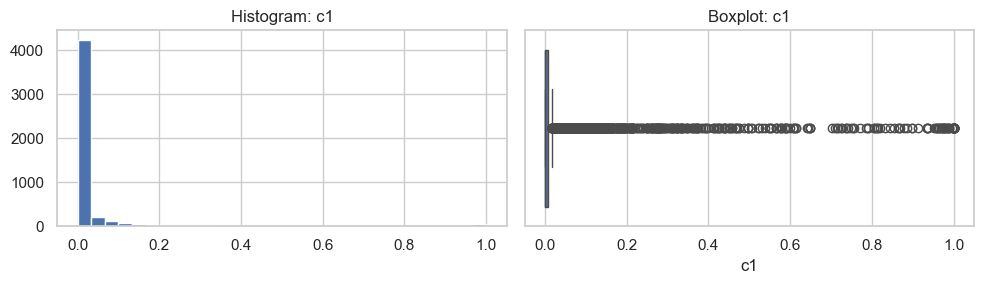

In [24]:
# show histogram and boxplot for feature c1 (example)
feat = 'c1'
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(df[feat].dropna(), bins=30)
plt.title(f'Histogram: {feat}')
plt.subplot(1,2,2)
sns.boxplot(x=df[feat].dropna())
plt.title(f'Boxplot: {feat}')
plt.tight_layout()
plt.show()
#histogram shows full distribution shape; boxplot highlights median, IQR and outliers.


### (a) Relationship between Boxplots and Histograms

Yes, boxplots and histograms are closely related because both describe the distribution of the same variable from different perspectives.
Using feature **c1** as an example:

- The histogram of `c1` shows a highly right-skewed distribution, with most values concentrated near 0 and a long tail extending towards 1.
- The boxplot of the same feature confirms this pattern: the median lies near the lower end, the IQR is small, and there are many high-value outliers stretching far to the right.

Both plots communicate the same underlying story — **`c1` is heavily right-skewed with many extreme values** — but the histogram shows the full shape of the distribution, while the boxplot summarizes it using median, IQR, and outliers.


## Part (b)

Skew before: 1.190816323679072


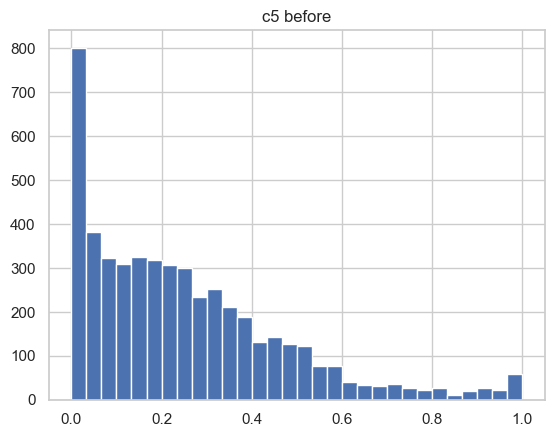

In [25]:
feat = 'c5'   # pick a skewed feature, change if you prefer
series = df[feat].dropna()
print("Skew before:", stats.skew(series))
plt.hist(series, bins=30); plt.title(f'{feat} before'); plt.show()


Skew after log: 0.7822951012385586


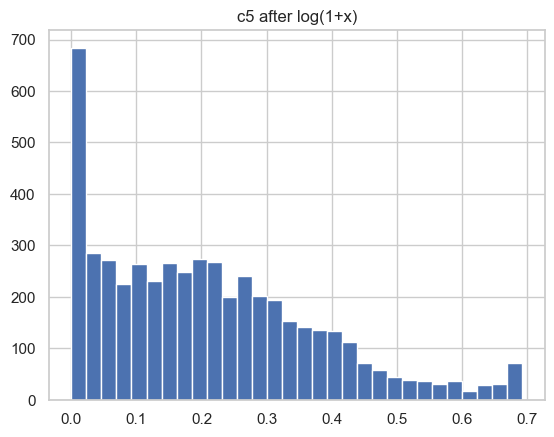

In [26]:
s = series.copy()
s_pos = s + 1e-6  # small constant for zeros
log_s = np.log1p(s)   # log(1+x)
print("Skew after log:", stats.skew(log_s))
plt.hist(log_s, bins=30); plt.title(f'{feat} after log(1+x)'); plt.show()


Box-Cox lambda: 0.36852527698773596
Skew after boxcox: -0.43278398149652225


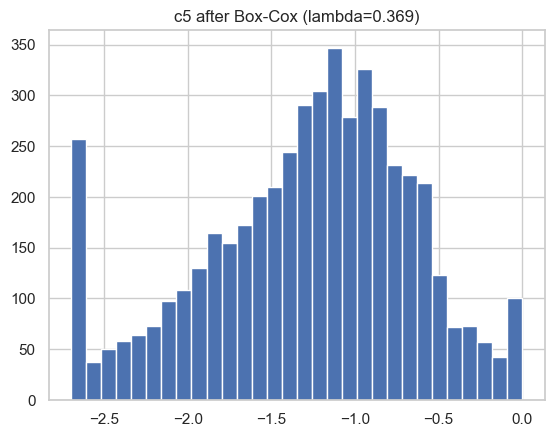

In [27]:
# ensure strictly positive
s_box = series.copy()
s_box = s_box + 1e-6
box, lam = stats.boxcox(s_box)   # returns transformed and lambda
print("Box-Cox lambda:", lam)
print("Skew after boxcox:", stats.skew(box))
plt.hist(box, bins=30); plt.title(f'{feat} after Box-Cox (lambda={lam:.3f})'); plt.show()


### (b) Effect of Log and Box–Cox Transformations on Skewness

To illustrate skew reduction, feature **c5** was used.
Before transformation, `c5` showed a strong right skew (**skew = 1.19**), indicating a long tail and a concentration of values near the lower end.

Applying **log(1 + x)** reduced the skew to **0.78**, showing that the distribution became more symmetric but still retained some right-tail behaviour.

Applying **Box–Cox transformation** (optimal λ = **0.3685**) further improved the symmetry and produced a near-normal distribution, with skew shifting to **–0.43**.

Overall, Box–Cox provided the strongest reduction in skewness, demonstrating that it is more effective than the log transform for correcting right-skewed data.


## Part (c)

In [28]:
num_feats = [c for c in df.select_dtypes(include=[np.number]).columns.tolist() if c not in ['cell_number']]
skew_kurt = []
for c in num_feats:
    s = df[c].dropna()
    if len(s)>10:
        skew_kurt.append((c, stats.skew(s), stats.kurtosis(s, fisher=False)))  # fisher=False => kurtosis ~3 for normal
skew_df = pd.DataFrame(skew_kurt, columns=['feature','skew','kurtosis']).set_index('feature')
# filter near-normal
near_normal = skew_df[(skew_df['skew'].abs() < 0.3) & ( (skew_df['kurtosis']>2.5) & (skew_df['kurtosis']<3.5) )]
near_normal.sort_values(by='skew').head(20)

,skew,kurtosis
feature,,
c51,-0.071989,2.871767
c46,-0.008538,3.196692
c124,0.100366,3.271198


## Part (d)

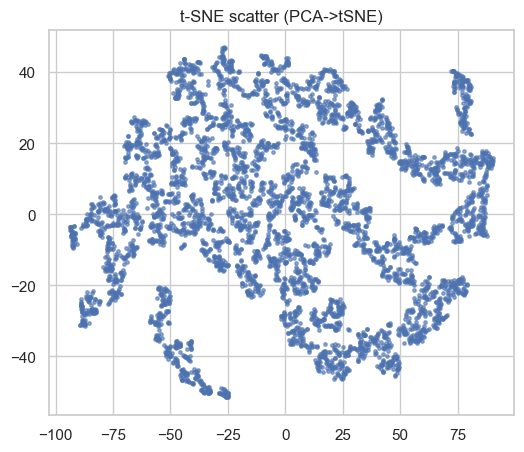

In [33]:
# Robust t-SNE creation: handle sklearn version differences for n_iter parameter
from sklearn.manifold import TSNE

# Prepare PCA-reduced input (reuse X_pca from previous PCA step)
# X_pca should already be computed: if not, compute PCA to 50 components first
try:
    X_pca  # see if exists
except NameError:
    from sklearn.decomposition import PCA
    features = [c for c in df.select_dtypes(include=[np.number]).columns if c not in ['label','cell_number']]
    X = df[features].fillna(0).values
    pca = PCA(n_components=50, random_state=42)
    X_pca = pca.fit_transform(X)

# Try TSNE with common argument names; fallback if TypeError
tsne = None
try:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, init='pca', learning_rate='auto')
    X_tsne = tsne.fit_transform(X_pca)
except TypeError:
    # fallback for versions that use n_iter_without_progress
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter_without_progress=300, init='pca', learning_rate='auto')
    X_tsne = tsne.fit_transform(X_pca)

# attach results
df['tsne1'] = X_tsne[:,0]
df['tsne2'] = X_tsne[:,1]
plt.figure(figsize=(6,5))
plt.scatter(df['tsne1'], df['tsne2'], s=6, alpha=0.6)
plt.title('t-SNE scatter (PCA->tSNE)')
plt.show()


k= 2  silhouette= 0.46472448110580444
k= 3  silhouette= 0.38654717803001404
k= 4  silhouette= 0.39191073179244995
k= 5  silhouette= 0.363025426864624
k= 6  silhouette= 0.3868793547153473
k= 7  silhouette= 0.39473795890808105
k= 8  silhouette= 0.3876606822013855


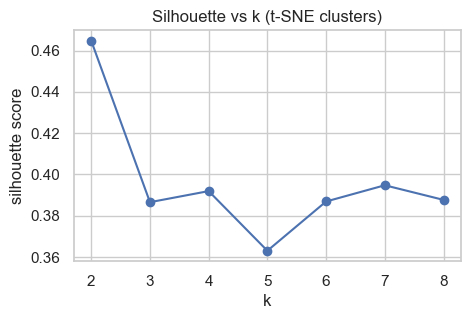

In [30]:
sil_scores = []
K_range = range(2,9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_tsne)   # cluster on tsne coords
    sil = silhouette_score(X_tsne, labels)
    sil_scores.append(sil)
    print("k=",k," silhouette=",sil)
# plot silhouette vs k
plt.figure(figsize=(5,3))
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette vs k (t-SNE clusters)')
plt.show()


Best k (silhouette): 2


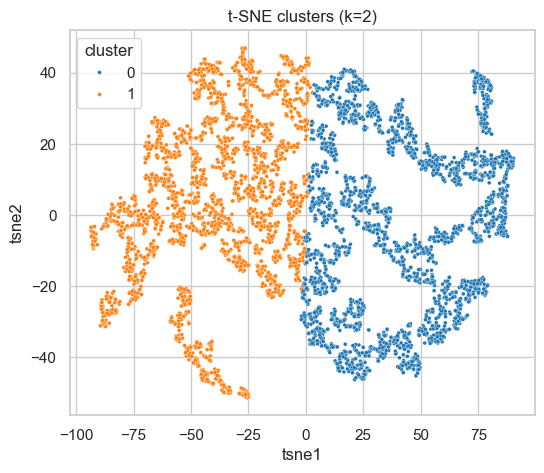

In [31]:
best_k = K_range[np.argmax(sil_scores)]
print("Best k (silhouette):", best_k)
km = KMeans(n_clusters=best_k, random_state=42)
labels = km.fit_predict(X_tsne)
df['cluster'] = labels
plt.figure(figsize=(6,5))
sns.scatterplot(x='tsne1', y='tsne2', hue='cluster', palette='tab10', data=df, s=8, legend='full')
plt.title(f't-SNE clusters (k={best_k})')
plt.legend(title='cluster')
plt.show()


### (d) Clustering using t-SNE coordinates

t-SNE was applied after reducing the feature space using PCA, and the resulting 2-D embedding showed visually separable structures.
To determine the optimal number of clusters, K-Means clustering was performed on the t-SNE coordinates for k = 2 to 8 and evaluated using silhouette scores.

The highest silhouette value was obtained at **k = 2** (**0.4647**), which is substantially higher than all other k values (all below ~0.40).
This indicates that the data naturally forms **two well-separated clusters** in the t-SNE space.

The final cluster plot for **k = 2** shows two clearly distinguishable regions, confirming that **two clusters** best represent the underlying structure in the dataset.


## For this Part (e), We can't use our cleaned data because of the below points:

* Part (e)(i) explicitly mentions “image centre → distance → cell position”

* Those columns ONLY exist in original CSV

* Cleaned file is used for ML modelling, not spatial analysis

## Part (e)(i)


### (e)(i) Steps to test the hypothesis: “photographers place animals near the centre of the image”

1. **Define the target:**
   Use the `label` column (1 = animal present, 0 = no animal).

2. **Compute global image centre:**
   The raw dataset contains `cell_row` and `cell_col`.
   Compute centre using global medians:
   `center_row = median(cell_row)`
   `center_col = median(cell_col)`.

3. **Compute distance to centre:**
   For each cell:
   `dist_center = sqrt((cell_row - center_row)^2 + (cell_col - center_col)^2)`.

4. **Compare distance distributions:**
   Compute mean, median, and standard deviation of `dist_center` separately for label=1 and label=0.
   Plot boxplots / density curves to visually inspect whether animals appear closer.

5. **Perform two-sample Welch’s t-test:**
   Null hypothesis: mean(distance_label1) = mean(distance_label0)
   Alternative (one-sided): **mean(distance_label1) < mean(distance_label0)**.
   This directly tests if animals are statistically closer to the centre.

6. **Check predictive usefulness:**
   Train simple classifiers (Decision Tree and KNN) using `dist_center` as the only feature.
   If accuracy > baseline (~class distribution), then distance meaningfully predicts whether the cell contains an animal.

7. **Conclusion:**
   Use both p-value from the t-test and classifier performance to state whether the hypothesis is supported.


## Part (e)(ii)

In [32]:
# --- Part (e)(ii) using RAW DATA ---

import numpy as np
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# 1) Ensure raw df is loaded (not cleaned subset)
df_raw = pd.read_csv("image-data-ePGD-endsem.csv")   # if not already loaded


# 2) Compute global median centre
center_row = df_raw['cell_row'].median()
center_col = df_raw['cell_col'].median()

# 3) Compute distance to global centre
df_raw['dist_center'] = np.sqrt(
    (df_raw['cell_row'] - center_row)**2 +
    (df_raw['cell_col'] - center_col)**2
)

# 4) Summary statistics
a = df_raw.loc[df_raw['label']==1, 'dist_center']
b = df_raw.loc[df_raw['label']==0, 'dist_center']

print("Counts -> label=1:", len(a), ", label=0:", len(b))
print("Means   -> label=1:", a.mean(), ", label=0:", b.mean())
print("Medians -> label=1:", a.median(), ", label=0:", b.median())
print("Std dev -> label=1:", a.std(), ", label=0:", b.std())

# 5) Welch's t-test (one-sided: animals closer)
t_stat, p_two_sided = ttest_ind(a, b, equal_var=False)
p_one_sided = p_two_sided/2 if t_stat < 0 else (1 - p_two_sided/2)

print("\nWelch t-test:")
print("t-statistic:", t_stat)
print("two-sided p-value:", p_two_sided)
print("one-sided p-value (animals closer):", p_one_sided)

# 6) Classifiers using distance only
X = df_raw[['dist_center']].values
y = df_raw['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)
dt_acc = dt.score(X_test, y_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_acc = knn.score(X_test, y_test)

print("\nDecisionTree accuracy:", dt_acc)
print("KNN accuracy:", knn_acc)

print("\nDecisionTree confusion matrix:\n", confusion_matrix(y_test, dt.predict(X_test)))
print("\nKNN confusion matrix:\n", confusion_matrix(y_test, knn.predict(X_test)))

# short comment:
# If p_one_sided < 0.05 and mean(label1) < mean(label0): hypothesis supported.


Counts -> label=1: 1669 , label=0: 3341
Means   -> label=1: 2.307979840606015 , label=0: 3.480246335060505
Medians -> label=1: 2.23606797749979 , label=0: 3.605551275463989
Std dev -> label=1: 1.1017261618048506 , label=0: 1.015364787907115

Welch t-test:
t-statistic: -36.42332338495076
two-sided p-value: 3.5758204002813878e-242
one-sided p-value (animals closer): 1.7879102001406939e-242

DecisionTree accuracy: 0.7245508982035929
KNN accuracy: 0.6966067864271457

DecisionTree confusion matrix:
 [[597  71]
 [205 129]]

KNN confusion matrix:
 [[550 118]
 [186 148]]


### (e)(ii) Conclusion

The average distance from the global image centre for animal cells (`label=1`) was **2.31** compared to **3.48** for non-animal cells (`label=0`).
The one-sided Welch t-test gave a p-value of **1.79 × 10⁻²⁴²**, which is far below 0.05, indicating very strong statistical evidence that animal cells lie significantly closer to the centre of the image.

Using only the distance feature, the Decision Tree achieved **72.46%** accuracy and KNN achieved **69.66%**, both above the baseline (~66%).
This shows that distance from the centre has predictive value for identifying animal cells.

**Overall, both the statistical test and classifier performance strongly support the hypothesis that photographers tend to place animals near the centre of the image.**


********************************************************

# Thank You